In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Compress Oil Flow Data using Probabilistic PCA
## 3 Phase Data
### Description
This is synthetic data modelling non-intrusive measurements on a pipe-line transporting a mixture of oil, water and gas. The flow in the pipe takes one out of three possible configurations: horizontally stratified, nested annular or homogeneous mixture flow. The data lives in a 12-dimensional measurement space, but for each configuration, there is only two degrees of freedom: the fraction of water and the fraction of oil. (The fraction of gas is redundant, since the three fractions must sum to one.) Hence, the data lives on a number of ‘sheets’ which locally are approximately 2-dimensional.

### Details
The files/variables contain:
1. Oilflow.txt contains 1000 measurements,each measurement is represented by a 12 dimensional vector.
2. Oilflow_label.txt contains the configuration of each measurement represented as one-hot vector: (1, 0, 0) horizontally stratified, (0, 1, 0) nested annular and (0, 0, 1) homogeneous mixture.




Let's first import the data and configurations into x and x_label respectively. Also create lists of colors for further visualization (different colors indicates different configurations)

In [2]:
x = np.loadtxt('./data/Oilflow.txt')[..., np.newaxis]
x_label = np.loadtxt('./data/Oilflow_label.txt')
x_label = np.argmax(x_label, axis=1)

color = []
color_edge = []
shape = []
for i in range(x.shape[0]):
    if x_label[i] == 0:
        color += ['pink']
        color_edge += ['orange']
    elif x_label[i] == 1:
        color += ['green']
        color_edge += ['black']
    elif x_label[i] == 2:
        color += ['blue']
        color_edge += ['purple']

In [11]:
print(x[1:5,:].transpose())

[[[ 0.0939  0.5184  0.4208  0.313 ]
  [ 1.0089  0.2283  0.674   0.6465]
  [ 0.0365  0.53    0.1651  0.5908]
  [ 0.6944  0.6884  0.7592  0.6924]
  [ 0.0908  0.7456  0.181   0.7664]
  [ 0.4961  0.6171  0.5448  0.6262]
  [ 0.0722  0.6136  0.1707  1.7177]
  [ 0.6521  0.5928  0.7554  0.015 ]
  [-0.013   0.7678  0.1635  0.0851]
  [ 0.6085  0.613   0.5492  1.9046]
  [ 0.0631  0.6705  0.2598 -0.0165]
  [ 0.6597  0.5202  0.6455  0.0221]]]


Denote the dimension of each data point as d_dim (12) and define the dimension of the latent space as 2. Denote the n_dim as the number of data points.

In [3]:
d_dim = x.shape[-2]
z_dim = 2
n_dim = x.shape[0]

Assume $p(\mathbf{z}_i) = \mathcal{N}(\mathbf{0}, \mathbf{I})$ and $ \mathbf{x}_i = \mathbf{W}\mathbf{z}_i + \boldsymbol{\mu} + \boldsymbol{\epsilon}$ where $\boldsymbol{\epsilon} \sim \mathcal{N}(\mathbf{0}, \sigma^2\mathbf{I})$.

We are going to use EM algorithm to optimize parameters $\mathbf{W}, \boldsymbol{\mu}$ and $\sigma^2$.

Denote $\mathbf{W}$ as W, $\boldsymbol{\mu}$ as mu and $\sigma^2$ as sigma_2.

We iterate EM via following update equations

### E-step
We assign $q(\mathbf{z}_n) = p(\mathbf{z}_n|\mathbf{x},\mathbf{W}_{old},\boldsymbol{\mu}_{old},\sigma^2_{old})$

We evaluate 
\begin{align}
		    \mathbb{E}_{q(\mathbf{z}_n)}[\mathbf{z}_n] = \mathbf{M}^{-1}\mathbf{W}^T_{old}(\mathbf{x}_n-\boldsymbol{\mu}_M)
\end{align} where $\boldsymbol{\mu}_M = \frac{1}{N}\sum_{n=1}^N \mathbf{x}_n = \overline{\mathbf{x}}$ 

and
\begin{align}
			\mathbb{E}_{q(\mathbf{z}_n)}[\mathbf{z}_n\mathbf{z}_n^T] &= Cov(\mathbf{z}_n,\mathbf{z}_n) + \mathbb{E}_{q(\mathbf{z}_n)}[\mathbf{z}_n]\mathbb{E}_{q(\mathbf{z}_n)}[\mathbf{z}_n]^T\\
			&=\sigma^2\mathbf{M}^{-1}+\mathbb{E}_{q(\mathbf{z}_n)}[\mathbf{z}_n]\mathbb{E}_{q(\mathbf{z}_n)}[\mathbf{z}_n]^T
\end{align}

where $\mathbf{M} =\mathbf{W}_{old}^T\mathbf{W}_{old}+\sigma_{old}^2\mathbf{I}$

In [4]:
def E_step(W, sigma_2, mu):
    # a @ b = np.matmul(a,b); a * b is element-wise multiplication
    W_T = W.transpose((0, -1, -2))
    M = W_T @ W + sigma_2 * np.eye(z_dim)
    M_inv = np.linalg.inv(M)
    
    # compute E[z_n] as post_mean and E[z_n]^T @ E[z_n] as post_mean_dot
    post_mean = (M_inv @ W_T) @ (x-mu)
    post_mean_T = post_mean.transpose((0, -1, -2))
    post_cov = sigma_2 * M_inv

    post_mean_dot = post_cov + post_mean @ post_mean_T
    return post_mean, post_mean_dot

### M-step
Given the $\mathbb{E}_{q(\mathbf{z}_n)}[\mathbf{z}_n]$ and $\mathbb{E}_{q(\mathbf{z}_n)}[\mathbf{z}_n\mathbf{z}_n^T]$ computed in the E-step, we update the model parameters $\mathbf{W}$ and $\sigma^2$ (The $\boldsymbol{\mu}_M$ is computed as mu$=\frac{1}{N}\sum_{n=1}^N \mathbf{x}_n$).
\begin{align}
			\boldsymbol{\mu}_M &= \overline{\mathbf{x}} =\frac{1}{N}\sum_{n=1}^N \mathbf{x}_n \\
			\mathbf{W}_{new}&=\Big[\sum_{n=1}^{N}(\mathbf{x}_n-\boldsymbol{\mu}_M)\mathbb{E}_{q(\mathbf{z}_n)}[\mathbf{z}_n]^T \Big]\Big[\sum_{n=1}^{N}\mathbb{E}_{q(\mathbf{z}_n)}[\mathbf{z}_n\mathbf{z}_n^T]  \Big]^{-1}\\
			\sigma^2_{new} &= \frac{1}{ND}\sum_{n=1}^{N} \Big[||\mathbf{x}_n-\boldsymbol{\mu}_M||^2 + trace\big[\mathbb{E}_{q(\mathbf{z}_n)}[\mathbf{z}_n\mathbf{z}_n^T]\mathbf{W}^T\mathbf{W}\big] - 2\mathbb{E}_{q(\mathbf{z}_n)} [\mathbf{z}_n]^T\mathbf{W}^T(\mathbf{x}_n-\boldsymbol{\mu}_M)\Big]
		\end{align}



In [5]:
def M_step(x, W, sigma_2, mu, post_mean, post_mean_dot):
    post_mean_T = post_mean.transpose((0, -1, -2))
    W = ((x-mu) @ post_mean_T).sum(axis=0, keepdims=True) @ np.linalg.inv(post_mean_dot.sum(axis=0, keepdims=True))
    W_T = W.transpose((0, -1, -2))
    sigma_2 = (((x - mu) ** 2).sum(axis=-2)
               + np.trace(post_mean_dot @ W_T @ W, axis1=-2, axis2=-1)[..., np.newaxis]
               - (2 * post_mean_T @ W_T @ (x - mu)).squeeze(-1)
               ).sum(axis=0) / (d_dim * n_dim)
    return W, sigma_2

Put everythinh together, we can learn the model parameters and visualize the learnt 2-dimensional latent space.


itration:1, log-likelihood:3437.705460574749, epsilon:1.3196208657240027


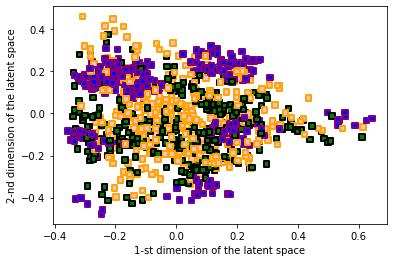

itration:2, log-likelihood:4224.5588972056485, epsilon:0.08841658301810634


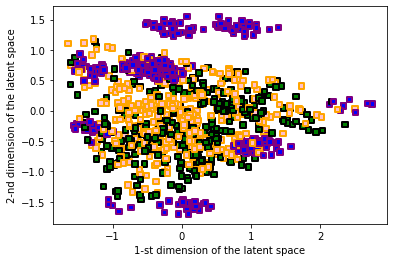

itration:3, log-likelihood:4641.356506794207, epsilon:0.06176640968376784


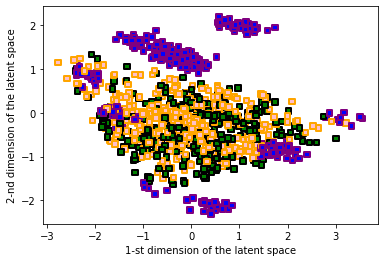

itration:4, log-likelihood:4905.818018824788, epsilon:0.0401678413100346


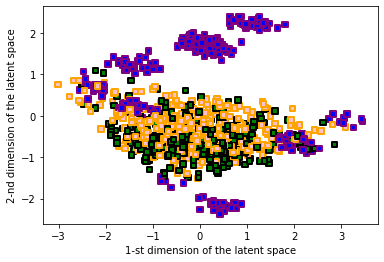

itration:5, log-likelihood:5168.138218732347, epsilon:0.025825032782911005


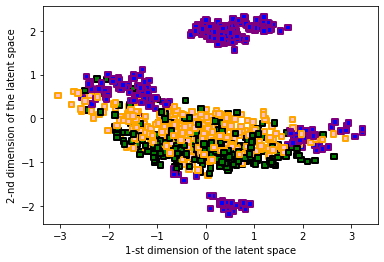

itration:6, log-likelihood:5410.000953016961, epsilon:0.01604348058989308


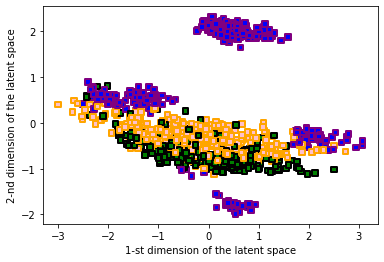

itration:7, log-likelihood:5597.8316783534565, epsilon:0.01017310607398401


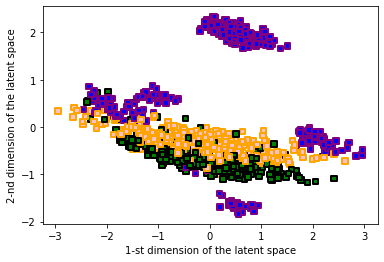

itration:8, log-likelihood:5727.434756936637, epsilon:0.006762555557360141


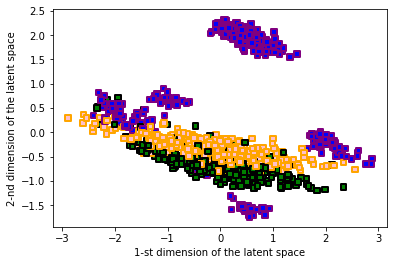

itration:9, log-likelihood:5811.419135436089, epsilon:0.004750640288903673


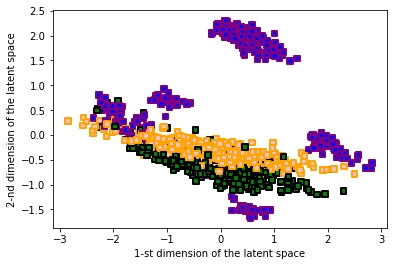

itration:10, log-likelihood:5864.443591219945, epsilon:0.003512681953008624


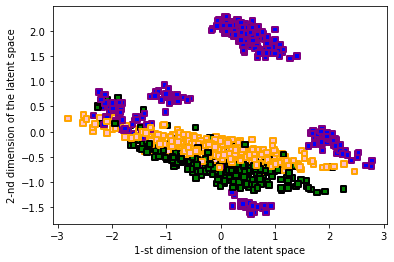

itration:11, log-likelihood:5897.827421642204, epsilon:0.0027028000204695323


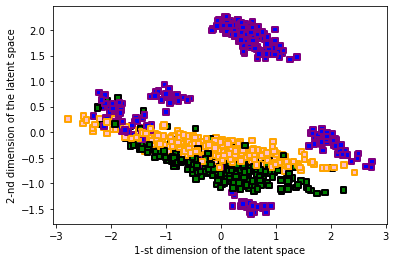

itration:12, log-likelihood:5919.104947795318, epsilon:0.002136858455791972


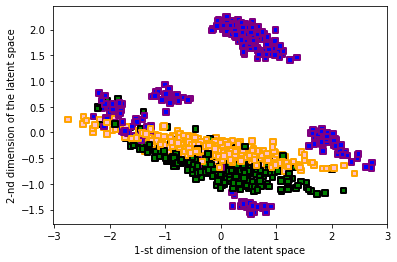

itration:13, log-likelihood:5932.971340996432, epsilon:0.0017186886647606542


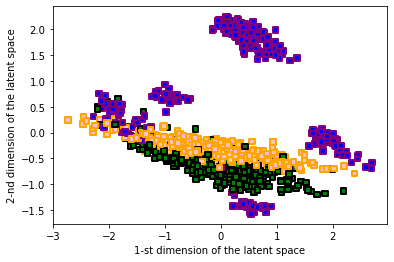

itration:14, log-likelihood:5942.269616217247, epsilon:0.001397167256257257


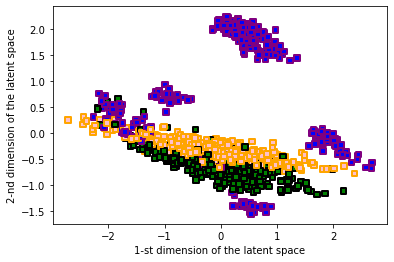

itration:15, log-likelihood:5948.705696527654, epsilon:0.0011435294810946937


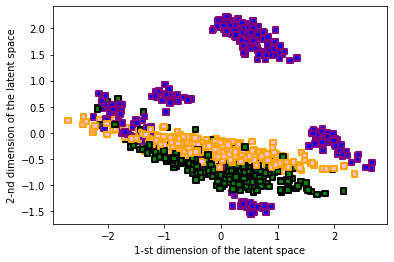

itration:16, log-likelihood:5953.30599764123, epsilon:0.0009402236959002202


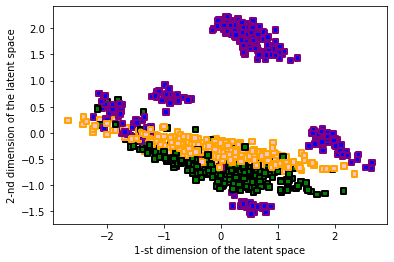

In [7]:
# initialize parameters
# x = wz + mu
W = np.random.rand(1, d_dim, z_dim)
W_T = W.transpose((0, -1, -2))
mu = np.mean(x, axis=0)

# sigma square
sigma_2 = np.exp2(np.random.rand(1))

# stop precision
epsilon = 1.0
# maximum iterations
max_itr = 100
# iteration count
itr = 0
# plotting frequency
plot_freq = 1

while epsilon > 0.001 and itr < max_itr:
    # E-step
    post_mean, post_mean_dot = E_step(W, sigma_2, mu)
    
    # M-step
    # save old W and sigma_2 for computing stop criterion
    _W = W.copy()
    _sigma_2 = sigma_2.copy()
    W, sigma_2 = M_step(x, W, sigma_2, mu, post_mean, post_mean_dot)
    
    
    epsilon = np.sqrt(np.mean((W-_W)**2) + np.mean((sigma_2-_sigma_2)**2))
    itr += 1
    
    # evaluate log-likelihood of original data log p(x) as log_px
    C = W @ W_T + sigma_2 * np.eye(d_dim)
    log_px = -0.5 * n_dim * np.log(np.linalg.det(C)) - 0.5 * ((x - mu).transpose((0, -1, -2)) @ np.linalg.inv(C) @ (x-mu)).sum(axis=0).squeeze(-1)

    print(f'itration:{itr}, log-likelihood:{log_px.item()}, epsilon:{epsilon}')

    # plot the z space
    if itr % plot_freq == 0:
        plt.scatter(post_mean[:, 0, 0], post_mean[:, 1, 0], c=color,
                    linewidths=2,
                    marker="s",
                    edgecolor=color_edge,
                    s=30)

        plt.xlabel("1-st dimension of the latent space")
        plt.ylabel("2-nd dimension of the latent space")
        plt.pause(3)
        
print("Finished!")